# StarCraft Dataset (3 classes)

## imports

In [3]:
# set plots inline for ipython
%matplotlib inline
import future        # pip install future

# general python imports
from time import time

# Standard scientific Python imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
plt.style.use('fivethirtyeight')

# hide warnings
import warnings
warnings.filterwarnings('ignore')

# import datasets, preprocessing, piplining, evaluation
from sklearn import datasets, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.image import grid_to_graph
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import train_test_split
from scipy.spatial.distance import cdist
from scipy.stats import kurtosis
from sklearn.metrics import accuracy_score
from scipy.stats import variation
import scipy.sparse as sps
from scipy.linalg import pinv


# clustering
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as GMM


# dimensionality reduction
from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection 
from sklearn.random_projection import SparseRandomProjection
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Supervised learning
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
cfont = {'fontname':'Comic Sans MS', 'fontsize':18}
hfont = {'fontname':'Comic Sans MS', 'fontsize':14}
vfont = {'fontname':'Comic Sans MS', 'fontsize':14}

/Users/qizhang/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
# set the figure sizes
plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'figure.figsize': (4,3)})

## load data

In [5]:
# load data
starcraft3=pd.read_csv('starcraft3_nomissing.csv', header=0)
starcraft3['LeagueIndex'] = starcraft3['LeagueIndex'].map({3:0,4:1,6:2})

In [6]:
# split train and test
train,test=train_test_split(starcraft3,test_size=0.2,random_state=0,stratify=starcraft3['LeagueIndex'])# stratify the outcome
X=train[train.columns[:18]] # X train
X_test=test[test.columns[:18]]
y=train['LeagueIndex'] # y train
y_test=test['LeagueIndex']

# fit a standardScaler to normalize all input to zero mean and unit variance
scaler = StandardScaler().fit(X)
X=scaler.transform(X)
X_test = scaler.transform(X_test)
y = np.array(y)
y_test=np.array(y_test)

In [7]:
print (X.shape)
print (X_test.shape)

(2670, 18)
(668, 18)


# 1. Clustering

## 1.1 k-means clustering
http://scikit-learn.org/stable/modules/clustering.html

In [8]:
#find optimized cluster number
meandist = []
ARI = []
AMI = []
h_score = []
c_score = []
V_measure = []
for k in range(1,11):
    kmeans = KMeans(init='random', n_clusters=k, n_init=10)
    Z = kmeans.fit_predict(X)
    # cluster average within k-means SSE
    min_ = np.min(np.square(cdist(X, kmeans.cluster_centers_, 'euclidean')), axis = 1)
    value = np.mean(min_)
    meandist.append(value)
    # other scores
    ARI.append(metrics.adjusted_rand_score(y, Z))
    AMI.append(metrics.adjusted_mutual_info_score(y, Z))
    h, c, V = metrics.homogeneity_completeness_v_measure(y, Z)
    h_score.append(h)
    c_score.append(c)
    V_measure.append(V)

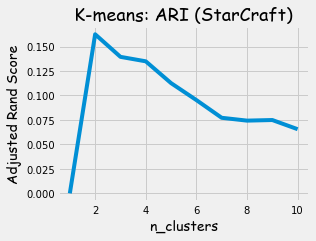

In [13]:
k = [1,2,3,4,5,6,7,8,9,10]
f = plt.figure()

plt.plot(k, ARI)

plt.title("K-means: ARI (StarCraft)", **cfont)
plt.xlabel('n_clusters', **hfont)
plt.ylabel('Adjusted Rand Score', **vfont);
plt.show()

f.savefig("star_01.pdf", bbox_inches='tight')



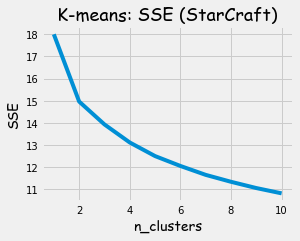

In [18]:
k = [1,2,3,4,5,6,7,8,9,10]
f = plt.figure()

plt.plot(k, meandist)

#plt.legend(loc='lower right')
plt.title("K-means: SSE (StarCraft)", **cfont)
#plt.ylim(0.92, 1.01)
#plt.xticks(np.arange(0,2.1,0.5))
plt.xlabel('n_clusters', **hfont)
plt.ylabel('SSE', **vfont);
plt.show()
f.savefig("star_02.pdf", bbox_inches='tight')



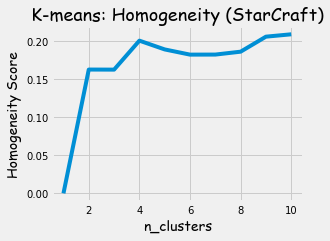

In [15]:
k = [1,2,3,4,5,6,7,8,9,10]
f = plt.figure()

plt.plot(k, h_score)

plt.title("K-means: Homogeneity (StarCraft)", **cfont)
plt.xlabel('n_clusters', **vfont)
plt.ylabel('Homogeneity Score', **hfont)
plt.show()
f.savefig("star_03.pdf", bbox_inches='tight')



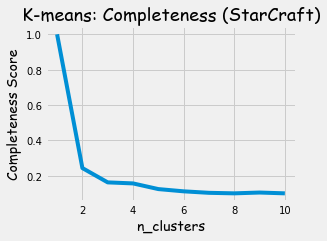

In [17]:
k = [1,2,3,4,5,6,7,8,9,10]
f = plt.figure()
plt.plot(k, c_score)

plt.title("K-means: Completeness (StarCraft)", **cfont)
plt.xlabel('n_clusters', **hfont)
plt.ylabel('Completeness Score', **vfont)
plt.show()
f.savefig("star_04.pdf", bbox_inches='tight')



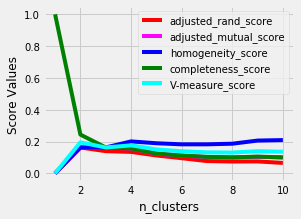

In [20]:
k = [1,2,3,4,5,6,7,8,9,10]
plt.plot(k, ARI, color='red', label='adjusted_rand_score')
plt.plot(k, AMI, color='magenta', label='adjusted_mutual_score')
plt.plot(k, h_score, color='blue', label='homogeneity_score')
plt.plot(k, c_score, color='green', label='completeness_score')
plt.plot(k, V_measure, color='cyan', label='V-measure_score')

plt.legend(loc='upper right')
#plt.title("KNN: unweighted (Cancer)")
#plt.ylim(0.92, 1.01)
#plt.xticks(np.arange(0,2.1,0.5))
plt.xlabel('n_clusters')
plt.ylabel('Score Values');
plt.show()
f.savefig("star_0p.pdf", bbox_inches='tight')



### improve K-means performance

In [23]:
# random init
start = time()
kmeans1 = KMeans(init='random', n_clusters=2, n_init=10)
Z = kmeans1.fit_predict(X)
print ('time: ', time() - start)
# cluster average within k-means SSE
min_ = np.min(np.square(cdist(X, kmeans.cluster_centers_, 'euclidean')), axis = 1)
value = np.mean(min_)
# other scores
ARI=metrics.adjusted_rand_score(y, Z)
AMI=metrics.adjusted_mutual_info_score(y, Z)
h, c, V = metrics.homogeneity_completeness_v_measure(y, Z)
print (value, ARI, AMI, h, c, V)

time:  0.04754996299743652
10.8099340758 0.162531757577 0.162488310266 0.162791465582 0.243611685498 0.195165333782


In [24]:
# k-means== init
start = time()
kmeans1 = KMeans(init='k-means++', n_clusters=2, n_init=10)
Z = kmeans1.fit_predict(X)
print ('time: ', time() - start)
# cluster average within k-means SSE
min_ = np.min(np.square(cdist(X, kmeans.cluster_centers_, 'euclidean')), axis = 1)
value = np.mean(min_)
# other scores
ARI=metrics.adjusted_rand_score(y, Z)
AMI=metrics.adjusted_mutual_info_score(y, Z)
h, c, V = metrics.homogeneity_completeness_v_measure(y, Z)
print (value, ARI, AMI, h, c, V)

time:  0.06942296028137207
10.8099340758 0.162531757577 0.162488310266 0.162791465582 0.243611685498 0.195165333782


## 1.2 EM clustering

In [25]:
#find optimized cluster number
ll = [] # log likelyhood
ARI = []
AMI = []
h_score = []
c_score = []
V_measure = []
bic = []
aic = []
for k in range(1,11):
    gmm = GMM(n_components=k, covariance_type='spherical')
    gmm.fit(X)
    Z = gmm.predict(X)
    ll.append(gmm.score(X))
    ARI.append(metrics.adjusted_rand_score(y, Z))
    AMI.append(metrics.adjusted_mutual_info_score(y, Z))
    h, c, V = metrics.homogeneity_completeness_v_measure(y, Z)
    h_score.append(h)
    c_score.append(c)
    V_measure.append(V)
    bic.append(gmm.bic(X))
    aic.append(gmm.aic(X))

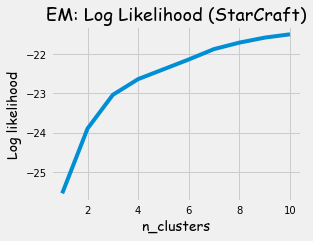

In [27]:
k = [1,2,3,4,5,6,7,8,9,10]
f = plt.figure()
plt.plot(k, ll)

plt.title("EM: Log Likelihood (StarCraft)", **cfont)
plt.xlabel('n_clusters', **hfont)
plt.ylabel('Log likelihood', **vfont);
plt.show()
f.savefig("star_06.pdf", bbox_inches='tight')



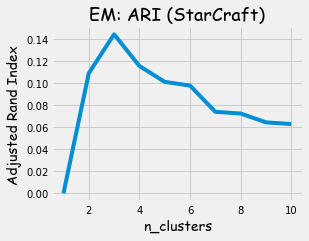

In [29]:
k = [1,2,3,4,5,6,7,8,9,10]
f = plt.figure()
plt.plot(k, ARI)

plt.title("EM: ARI (StarCraft)",  **cfont)
plt.xlabel('n_clusters', **hfont)
plt.ylabel('Adjusted Rand Index', **vfont)
plt.show()
f.savefig("star_07.pdf", bbox_inches='tight')



ValueError: x and y must have same first dimension, but have shapes (10,) and (1,)

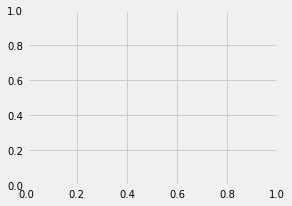

In [33]:
k = [1,2,3,4,5,6,7,8,9,10]
plt.plot(k, ARI, color='red', label='adjusted_rand_score')
plt.plot(k, AMI, color='magenta', label='adjusted_mutual_score')
plt.plot(k, h_score, color='blue', label='homogeneity_score')
plt.plot(k, c_score, color='green', label='completeness_score')
plt.plot(k, V_measure, color='cyan', label='V-measure_score')

plt.legend(loc='lower right')
#plt.title("KNN: unweighted (Cancer)")
#plt.ylim(0.92, 1.01)
#plt.xticks(np.arange(0,2.1,0.5))
plt.xlabel('n_clusters')
plt.ylabel('Score Values');
plt.show()

### improve EM

In [30]:
# spherical - kmeans start
start = time()
clf = GMM(n_components=3, covariance_type='spherical', random_state=42)
clf.fit(X)

clusters_EM = clf.predict(X)
print ('time: ', time() - start)

# scores
ll = clf.score(X)
ARI=metrics.adjusted_rand_score(y, clusters_EM)
AMI=metrics.adjusted_mutual_info_score(y, clusters_EM)
h, c, V = metrics.homogeneity_completeness_v_measure(y, clusters_EM)
print ('log likelihood, ARI, AMI, h, c, V')
print( ll, ARI, AMI, h, c, V)

time:  0.037747859954833984
log likelihood, ARI, AMI, h, c, V
-23.0417735344 0.14398261609 0.13983204732 0.140455238604 0.147571065809 0.143925252255


In [31]:
# spherical - random start
start = time()
clf = GMM(n_components=3, covariance_type='spherical', init_params='random',random_state=42)
clf.fit(X)
clusters_EM = clf.predict(X)
print( 'time: ', time() - start)

# scores
ll = clf.score(X)
ARI=metrics.adjusted_rand_score(y, clusters_EM)
AMI=metrics.adjusted_mutual_info_score(y, clusters_EM)
h, c, V = metrics.homogeneity_completeness_v_measure(y, clusters_EM)
print( 'log likelihood, ARI, AMI, h, c, V')
print( ll, ARI, AMI, h, c, V)

time:  0.013959884643554688
log likelihood, ARI, AMI, h, c, V
-23.0420654924 0.144359666391 0.140112209221 0.140735190254 0.147574869353 0.144073899769


In [120]:
# spherical - kmeans start
start = time()
clf = GMM(n_components=3, covariance_type='full', random_state=42)
clf.fit(X)
clusters_EM = clf.predict(X)
print('time: ', time() - start)

# scores
ll = clf.score(X)
ARI=metrics.adjusted_rand_score(y, clusters_EM)
AMI=metrics.adjusted_mutual_info_score(y, clusters_EM)
h, c, V = metrics.homogeneity_completeness_v_measure(y, clusters_EM)
print 'log likelihood, ARI, AMI, h, c, V'
print ll, ARI, AMI, h, c, V

time:  0.0936388969421
log likelihood, ARI, AMI, h, c, V
-11.9128355319 0.0271768105176 0.0298237073565 0.0305295798276 0.0411111749988 0.0350389077272


In [32]:
# tied - kmeans start
start = time()
clf = GMM(n_components=3, covariance_type='tied', random_state=42)
clf.fit(X)
clusters_EM = clf.predict(X)
print ('time: ', time() - start)

# scores
ll = clf.score(X)
ARI=metrics.adjusted_rand_score(y, clusters_EM)
AMI=metrics.adjusted_mutual_info_score(y, clusters_EM)
h, c, V = metrics.homogeneity_completeness_v_measure(y, clusters_EM)
print ('log likelihood, ARI, AMI, h, c, V')
print( ll, ARI, AMI, h, c, V)

time:  0.12976980209350586
log likelihood, ARI, AMI, h, c, V
-20.7319310629 0.0287668033178 0.0516080894362 0.0522976158143 0.110981481979 0.0710938140336


In [122]:
# diag - kmeans start
start = time()
clf = GMM(n_components=3, covariance_type='diag', random_state=42)
clf.fit(X)
clusters_EM = clf.predict(X)
print('time: ', time() - start)


# scores
ll = clf.score(X)
ARI=metrics.adjusted_rand_score(y, clusters_EM)
AMI=metrics.adjusted_mutual_info_score(y, clusters_EM)
h, c, V = metrics.homogeneity_completeness_v_measure(y, clusters_EM)
print 'log likelihood, ARI, AMI, h, c, V'
print ll, ARI, AMI, h, c, V

time:  0.0467529296875
log likelihood, ARI, AMI, h, c, V
-16.0753602591 0.044274131282 0.062999538187 0.0636787416711 0.0746904316609 0.0687464207309


## 1.3 Compare k means and EM

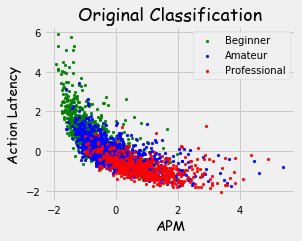

In [43]:
# original class
f = plt.figure()
k = 3 # number of clusters
colors = ['g', 'b', 'r', 'y', 'c', 'm']
labels = ['Beginner', 'Amateur', 'Professional']
fig, ax = plt.subplots()
for i in range(k):
    points = np.array([X[j] for j in range(len(X)) if y[j] == i])
    ax.scatter(points[:, 3], points[:, 11], s=7, c=colors[i], label=labels[i])
plt.xlabel("APM", **hfont)
plt.ylabel("Action Latency", **vfont)
plt.legend(loc=1)
plt.title('Original Classification', **cfont)
fig.savefig("star_10.pdf", bbox_inches='tight')



time:  0.11332511901855469
value, ARI, AMI, h, c, V
10.8099340758 0.139479770334 0.162076076552 0.162690550147 0.162682957436 0.162686753703
wrongly labeled: 0.4917602996254682


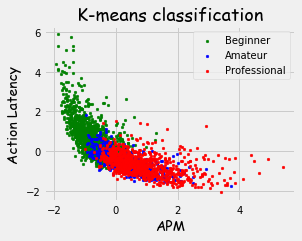

In [42]:
# K means classification
start = time()
clf = KMeans(init='k-means++', n_clusters=3, n_init=10, random_state=42)
Z=clf.fit_predict(X)
print ('time: ', time() - start)

# cluster average within k-means SSE
min_ = np.min(np.square(cdist(X, kmeans.cluster_centers_, 'euclidean')), axis = 1)
value = np.mean(min_)
# other scores
ARI=metrics.adjusted_rand_score(y, Z)
AMI=metrics.adjusted_mutual_info_score(y, Z)
h, c, V = metrics.homogeneity_completeness_v_measure(y, Z)
print( 'value, ARI, AMI, h, c, V')
print (value, ARI, AMI, h, c, V)

f = plt.figure()


# fix labels
clusters_kmeans = np.choose(clf.labels_, [2, 0, 1])
#clusters_kmeans = clf.labels_

k = 3 # number of clusters
colors = ['g', 'b', 'r', 'y', 'c', 'm']
labels = ['Beginner', 'Amateur', 'Professional']

fig, ax = plt.subplots()
for i in range(k):
    points = np.array([X[j] for j in range(len(X)) if clusters_kmeans[j] == i])
    ax.scatter(points[:, 3], points[:, 11], s=7, c=colors[i], label=labels[i])

# wrongly labeled points
points = np.array([X[j] for j in range(len(X)) if y[j] != clusters_kmeans[j]])
#ax.scatter(points[:, 3], points[:, 7], s=80, facecolors='none', edgecolors='m', label='Wrongly Labeled')
plt.xlabel("APM", **vfont)
plt.ylabel("Action Latency", **vfont)
plt.legend(loc=1)
plt.title('K-means classification', **cfont)
print ('wrongly labeled:', 1.0*len(points)/len(X))
fig.savefig("star_11.pdf", bbox_inches='tight')



time:  0.041285037994384766
log likelihood, ARI, AMI, h, c, V
-23.0417735344 0.14398261609 0.13983204732 0.140455238604 0.147571065809 0.143925252255
wrongly labeled: 0.43108614232209735


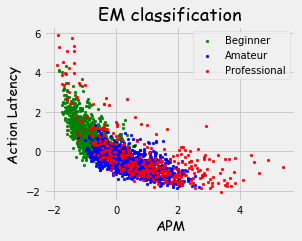

In [41]:
# EM classification
start = time()
clf = GMM(n_components=3, covariance_type='spherical', random_state=42)
clf.fit(X)
clusters_EM = clf.predict(X)
print ('time: ', time() - start)

# scores
ll = clf.score(X)
ARI=metrics.adjusted_rand_score(y, clusters_EM)
AMI=metrics.adjusted_mutual_info_score(y, clusters_EM)
h, c, V = metrics.homogeneity_completeness_v_measure(y, clusters_EM)
print ('log likelihood, ARI, AMI, h, c, V')
print (ll, ARI, AMI, h, c, V)

# fix labels
clusters_EM = np.choose(clusters_EM, [2,1,0])

k = 3 # number of clusters
colors = ['g', 'b', 'r', 'y', 'c', 'm']
labels = ['Beginner', 'Amateur', 'Professional']

fig, ax = plt.subplots()
for i in range(k):
    points = np.array([X[j] for j in range(len(X)) if clusters_EM[j] == i])
    ax.scatter(points[:, 3], points[:, 11], s=7, c=colors[i], label=labels[i])

# wrongly labeled points
points = np.array([X[j] for j in range(len(X)) if y[j] != clusters_EM[j]])
#ax.scatter(points[:, 1], points[:, 2], s=80, facecolors='none', edgecolors='m', label='Wrongly Labeled')
plt.xlabel("APM", **hfont)
plt.ylabel("Action Latency", **vfont)
plt.legend(loc=1)
plt.title('EM classification', **cfont)
fig.savefig("star_12.pdf", bbox_inches='tight')


print( 'wrongly labeled:', 1.0*len(points)/len(X))

# 2. Dimensionality Reduction

## 2.1 PCA

### PCA - select pca parameter

In [45]:
pca = PCA()
pca.fit(X)
print( pca.explained_variance_ratio_)

[ 0.26454639  0.11717972  0.0833962   0.06919522  0.05996999  0.05524895
  0.05460758  0.04553127  0.04325171  0.04102496  0.04015013  0.03233261
  0.02846721  0.02320552  0.02055727  0.01423467  0.006254    0.00084659]


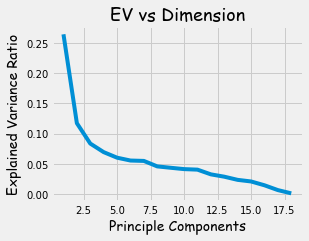

In [53]:
#Plot Variance Ratio for PCA
f = plt.figure()
plt.plot(range(1, 19), pca.explained_variance_ratio_)
plt.xlabel('Principle Components', **hfont)
plt.ylabel('Explained Variance Ratio', **hfont)
plt.title('EV vs Dimension', **cfont)
plt.show()
plt.clf()
f.savefig("star_13.pdf", bbox_inches='tight')



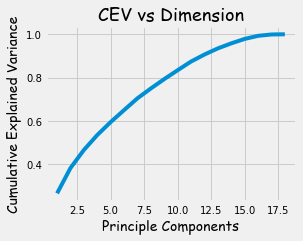

In [59]:
cummulative_explained_variance_ = np.cumsum(pca.explained_variance_ratio_)
f = plt.figure()

plt.plot(range(1, 19), cummulative_explained_variance_)
plt.xlabel('Principle Components', **hfont)
plt.ylabel('Cumulative Explained Variance', **hfont)
plt.title('CEV vs Dimension', **cfont)
plt.show()
plt.clf()
f.savefig("star_14.pdf", bbox_inches='tight')



In [52]:
acc = []
rmse_pca = []
for i in range (1, 19):
    pca = PCA(n_components=i)
    pca.fit(X)
    X_pca = pca.transform(X)
    X_projected = pca.inverse_transform(X_pca)
    mse = ((X - X_projected)**2).mean()
    rmse_pca.append(np.sqrt(mse))
    clf = DecisionTreeClassifier(max_depth=5)
    #clf = KNeighborsClassifier(n_neighbors=25)
    clf.fit(X_pca, y)
    acc.append(clf.score(X_pca, y))

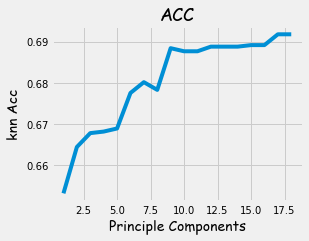

In [56]:
f = plt.figure()
plt.plot(range(1, 19), acc)
plt.xlabel('Principle Components', **hfont)
plt.ylabel('knn Acc', **hfont)
plt.title('ACC', **cfont)
plt.show()
plt.clf()
f.savefig("star_15.pdf", bbox_inches='tight')



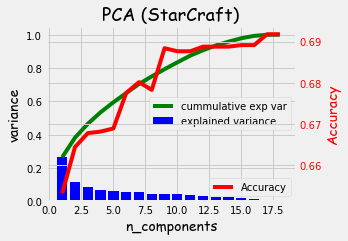

In [61]:
# final graph
fig, ax1 = plt.subplots()
x_range = range(1, 19)
ax1.bar(x_range, pca.explained_variance_ratio_, color='blue', label='explained variance')
ax1.plot(x_range, cummulative_explained_variance_, color='green', label='cummulative exp var')
ax1.set_xlabel('n_components', **hfont)
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('variance', **hfont)
ax1.legend(loc=5)

#ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(x_range, acc, color='red', label='Accuracy')
ax2.set_ylabel('Accuracy', color='r', **hfont)
ax2.tick_params('y', colors='r')
ax2.legend(loc=4)

plt.title('PCA (StarCraft)', **cfont)
plt.show()
fig.savefig("star_16.pdf", bbox_inches='tight')



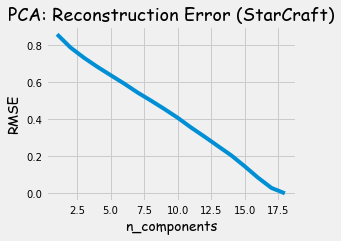

In [62]:
fig = plt.figure()
plt.plot(range(1, 19), rmse_pca)
plt.xlabel('n_components', **hfont)
plt.title('PCA: Reconstruction Error (StarCraft)', **cfont)
plt.ylabel('RMSE', **hfont)
plt.show()
plt.clf()
fig.savefig("star_17.pdf", bbox_inches='tight')



time:  0.006367921829223633


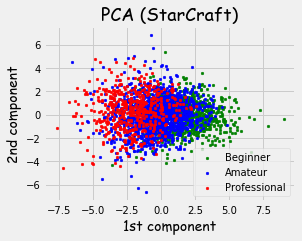

In [65]:
# PCA Plot
start = time()
X_pca = PCA(n_components=9).fit_transform(X)
print ('time: ', time() - start)

k = 3 # number of clusters
colors = ['g', 'b', 'r', 'y', 'c', 'm']
labels = ['Beginner', 'Amateur', 'Professional']

fig, ax = plt.subplots()
for i in range(k):
    points = np.array([X_pca[j] for j in range(len(X_pca)) if y[j] == i])
    ax.scatter(points[:, 0], points[:, 1], s=7, c=colors[i], label=labels[i])

# wrongly labeled points
#points = np.array([X[j] for j in range(len(X)) if y[j] != clusters_EM[j]])
#ax.scatter(points[:, 1], points[:, 2], s=80, facecolors='none', edgecolors='m', label='Wrongly Labeled')
plt.xlabel("1st component", **vfont)
plt.ylabel("2nd component", **vfont)
plt.legend(loc=4)
#plt.text(0.9, 0.9,'time: 3.8 ms', ha='center', va='center', transform=ax.transAxes)
plt.title('PCA (StarCraft)', **cfont)
fig.savefig("star_18.pdf", bbox_inches='tight')



## 2.2 ICA

### ICA parameter

In [66]:
ic_kurts=[]
for i in range(18):
    ic_kurt=kurtosis(X)
    ic_kurts.append(np.abs(kurtosis(X[i])))

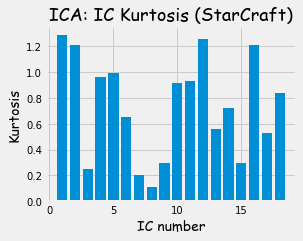

In [67]:
#plt.plot(kurts)
f = plt.figure()
plt.bar(range(1, 19), ic_kurts)
plt.xlabel('IC number', **vfont)
plt.ylabel('Kurtosis', **vfont)
plt.title('ICA: IC Kurtosis (StarCraft)', **cfont)
plt.xticks(np.arange(0, 18, 5))
plt.show()
f.savefig("star_19.pdf", bbox_inches='tight')



In [68]:
kurts = []
for i in range (1, 19):
    ica = FastICA(n_components=i, whiten=True)
    output =ica.fit_transform(X)
    kurt = np.average(np.abs(kurtosis(output)))
    kurts.append(kurt)

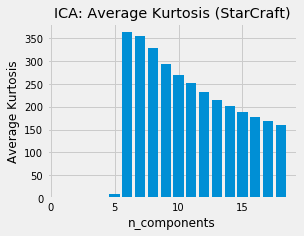

In [69]:
#plt.plot(kurts)
fig = plt.figure()
plt.bar(range(1, 19), kurts)
plt.xlabel('n_components')
plt.ylabel('Average Kurtosis')
plt.title('ICA: Average Kurtosis (StarCraft)')
plt.xticks(np.arange(0, 18, 5))

plt.show()
fig.savefig("star_20.pdf", bbox_inches='tight')



In [70]:
acc=[]
for i in range (1, 19):
    ica = FastICA(n_components=i, whiten=True)
    X_ica =ica.fit_transform(X)
    #clf = DecisionTreeClassifier(max_depth=5)
    clf = KNeighborsClassifier(n_neighbors=25)
    clf.fit(X_ica, y)
    acc.append(clf.score(X_ica, y))

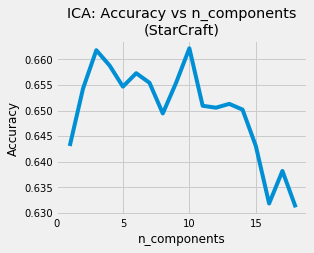

In [71]:
plt.plot(range(1, 19), acc)
plt.xlabel('n_components')
plt.title('ICA: Accuracy vs n_components\n(StarCraft)')
plt.ylabel('Accuracy')
plt.xticks(np.arange(0, 18, 5))

plt.show()

plt.clf()

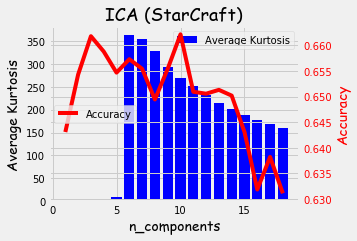

In [74]:
# final graph
fig, ax1 = plt.subplots()
x_range = range(1, 19)
ax1.bar(x_range, kurts, color='blue', label='Average Kurtosis')
ax1.set_xlabel('n_components', **vfont)
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Average Kurtosis', **vfont)
ax1.legend(loc=1)
plt.xticks(np.arange(0, 18, 5))


#ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(x_range, acc, color='red', label='Accuracy')
ax2.set_ylabel('Accuracy', color='r', **vfont)
ax2.tick_params('y', colors='r')
ax2.legend(loc=6)

plt.title('ICA (StarCraft)', **cfont)
plt.show()
fig.savefig("star_21.pdf", bbox_inches='tight')



## 2.3 Random Projection

why pca or rp
https://stats.stackexchange.com/questions/235632/pca-vs-random-projection

With very high dimensions, if speed is an issue, then consider that on a matrix of size n×kn×k, PCA takes O(k2×n+k3)O(k2×n+k3) time, whereas a random projection takes O(nkd)O(nkd), where you're projecting on a subspace of size dd.

With a sparse matrix its even faster.

The data may well be low-dimensional, but not in a linear subspace. PCA assumes this.

Random projection are also quite fast for reducing the dimension of a mixture of Gaussians.

If the data is very large, you don't need to hold it in memory for a random projections, whereas for PCA you do.

In general PCA works well on relatively low dimensional data.

Of course, PCA maintains the best possible projection. But it seems like you don't care about that for this purpose.

### RP parameter

In [75]:
acc1=[]
for i in range(1, 19):
    rp1 = SparseRandomProjection(n_components=i, random_state=10)
    X_rp1 =rp1.fit_transform(X)
    #clf = DecisionTreeClassifier(max_depth=5)
    clf = KNeighborsClassifier(n_neighbors=5)
    clf.fit(X_rp1, y)
    acc1.append(clf.score(X_rp1, y))

acc2=[]
for i in range(1, 19):
    rp2 = SparseRandomProjection(n_components=i, random_state=20)
    X_rp2 =rp2.fit_transform(X)
    #clf = DecisionTreeClassifier(max_depth=5)
    clf = KNeighborsClassifier(n_neighbors=5)
    clf.fit(X_rp2, y)
    acc2.append(clf.score(X_rp2, y))

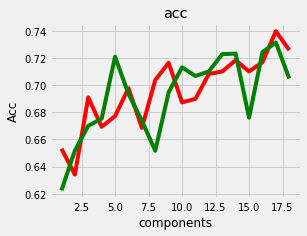

In [76]:
plt.plot(range(1, 19), acc1, color='r')
plt.plot(range(1, 19), acc2, color='g')

plt.xlabel('components')
plt.ylabel('Acc')
plt.title('acc')
plt.show()

In [77]:
def reconstructionError(projections,X):
    W = projections.components_
    if sps.issparse(W):
        W = W.todense()
    p = pinv(W)
    #reconstructed = ((p@W)@(X.T)).T # Unproject projected data
    reconstructed = (np.dot(np.dot(p, W), (X.T))).T # Unproject projected data
    errors = np.square(X-reconstructed)
    return np.sqrt(np.nanmean(errors)) #RMSE

In [78]:
acc_avg=[]
rmse_avg=[]
var =[]
for i in range(1, 19):
    acc=[]
    rmse=[]
    for rand in range(100):
        rp = SparseRandomProjection(n_components=i, random_state=rand)
        rp.fit(X)
        X_rp =rp.transform(X)
        #clf = DecisionTreeClassifier(max_depth=5)
        rmse.append(reconstructionError(rp, X))
        clf = KNeighborsClassifier(n_neighbors=25)
        clf.fit(X_rp, y)
        acc.append(clf.score(X_rp, y))
    acc_avg.append(np.average(acc))
    rmse_avg.append(np.average(rmse))
    var.append(variation(acc))

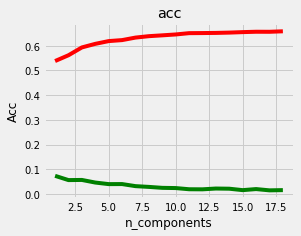

In [79]:
plt.plot(range(1, 19), acc_avg, color='r')
plt.plot(range(1, 19), var, color='g')

plt.xlabel('n_components')
plt.ylabel('Acc')
plt.title('acc')
plt.show()

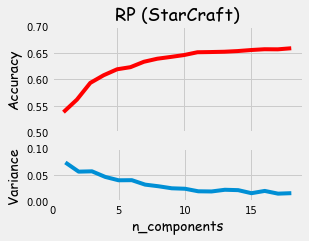

In [83]:
from matplotlib import gridspec

fig = plt.figure()
# set height ratios for sublots
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1]) 

# the fisrt subplot
ax1 = plt.subplot(gs[0])
ax1.plot(range(1, 19), acc_avg, color='r')
ax1.set_title('RP (StarCraft)', **cfont)
ax1.set_ylim(0.5, 0.7)
ax1.set_ylabel('Accuracy', **hfont)

#the second subplot
# shared axis X
ax2 = plt.subplot(gs[1], sharex = ax1)
ax2.plot(range(1, 19), var)
ax2.set_ylim(0,0.1)
ax2.set_ylabel('Variance', **hfont)
ax2.set_xlabel('n_components', **hfont)
plt.setp(ax1.get_xticklabels(), visible=False)

# remove vertical gap between subplots
#plt.subplots_adjust(hspace=.0)
plt.xticks(np.arange(0, 18, 5))

plt.show()
fig.savefig("star_31.pdf", bbox_inches='tight')



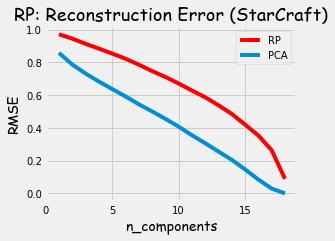

In [85]:
fig = plt.figure()
plt.plot(range(1, 19), rmse_avg, color='r', label='RP')
plt.plot(range(1, 19), rmse_pca, label='PCA')
plt.xticks(np.arange(0, 18, 5))

plt.xlabel('n_components', **vfont)
plt.title('RP: Reconstruction Error (StarCraft)', **cfont)
plt.ylabel('RMSE', **vfont)
plt.legend(loc=1)
plt.show()
fig.savefig("star_32.pdf", bbox_inches='tight')



## 2.4 LDA

### LDA parameter
This is the relevant, dimension-reducing line of LDA.transform, it uses scalings_. As described in the docstring, scalings_ has maximally n_classes - 1 columns. This is then the maximal number of columns you can hope to obtain using transform. In your case, 2 classes (True, False), yields maximally 1 column.

In [225]:
score = []
lda=[]
lda.append(LDA().fit(X,y)) # default solver='svd'
lda.append(LDA(solver='lsqr', shrinkage='auto').fit(X, y))
lda.append(LDA(solver='lsqr', shrinkage=None).fit(X, y))
lda.append(LDA(solver='eigen', shrinkage='auto').fit(X, y))
lda.append(LDA(solver='eigen', shrinkage=None).fit(X, y))
for i in range(len(lda)):
    score.append(lda[i].score(X,y))

In [226]:
print score

[0.6629213483146067, 0.66067415730337076, 0.6629213483146067, 0.66591760299625469, 0.66479400749063666]


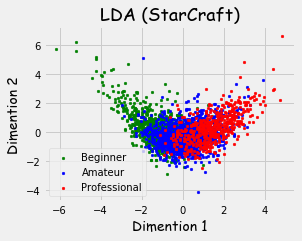

In [87]:
# sample distribution after LDA
lda = LDA().fit(X,y)
X_lda = lda.transform(X)

k = 3 # number of clusters
colors = ['g', 'b', 'r', 'y', 'c', 'm']
labels = ['Beginner', 'Amateur', 'Professional']

fig, ax = plt.subplots()
for i in range(k):
    points = np.array([X_lda[j] for j in range(len(X_lda)) if y[j] == i])
    ax.scatter(points[:, 0], points[:, 1], s=7, c=colors[i], label=labels[i])
plt.xlabel("Dimention 1", **vfont)
plt.ylabel("Dimention 2", **vfont)
plt.legend(loc=3)
plt.title('LDA (StarCraft)', **cfont)
fig.savefig("star_33.pdf", bbox_inches='tight')



# 3. Clustering with DR

### PCA - original

time:  0.00861096382141


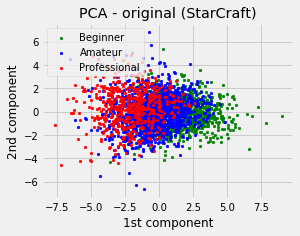

In [293]:
# PCA Plot
start = time()
X_pca = PCA(n_components=9).fit_transform(X)
print 'time: ', time() - start

k = 3 # number of clusters
colors = ['g', 'b', 'r', 'y', 'c', 'm']
labels = ['Beginner', 'Amateur', 'Professional']

fig, ax = plt.subplots()
for i in range(k):
    points = np.array([X_pca[j] for j in range(len(X_pca)) if y[j] == i])
    ax.scatter(points[:, 0], points[:, 1], s=7, c=colors[i], label=labels[i])

plt.xlabel("1st component")
plt.ylabel("2nd component")
plt.legend(loc=2)
plt.title('PCA - original (StarCraft)')

### PCA kmeans

In [277]:
#find optimized cluster number
ARI = []
AMI = []
h_score = []
c_score = []
V_measure = []
for k in range(1,11):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
    Z = kmeans.fit_predict(X_pca)
    ARI.append(metrics.adjusted_rand_score(y, Z))
    AMI.append(metrics.adjusted_mutual_info_score(y, Z))
    h, c, V = metrics.homogeneity_completeness_v_measure(y, Z)
    h_score.append(h)
    c_score.append(c)
    V_measure.append(V)

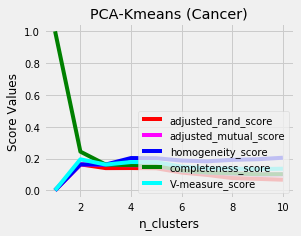

In [278]:
k = [1,2,3,4,5,6,7,8,9,10]
plt.plot(k, ARI, color='red', label='adjusted_rand_score')
plt.plot(k, AMI, color='magenta', label='adjusted_mutual_score')
plt.plot(k, h_score, color='blue', label='homogeneity_score')
plt.plot(k, c_score, color='green', label='completeness_score')
plt.plot(k, V_measure, color='cyan', label='V-measure_score')

plt.legend(loc='lower right')
plt.title("PCA-Kmeans (Cancer)")
#plt.ylim(0.92, 1.01)
#plt.xticks(np.arange(0,2.1,0.5))
plt.xlabel('n_clusters')
plt.ylabel('Score Values');
plt.show()

time:  0.127753019333
wrongly labeled: 0.501498127341


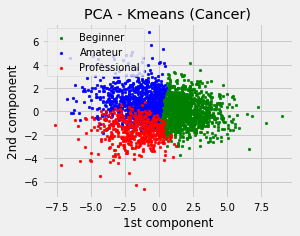

In [294]:
# PCA-kmeans Plot
start = time()
clf = KMeans(init='k-means++', n_clusters=3, random_state=42)
clf.fit_predict(X_pca)
print 'time: ', time() - start

k = 3 # number of clusters
colors = ['g', 'b', 'r', 'y', 'c', 'm']
labels = ['Beginner', 'Amateur', 'Professional']

# fix labels
clusters_kmeans = np.choose(clf.labels_, [1, 0, 2])


fig, ax = plt.subplots()
for i in range(k):
    points = np.array([X_pca[j] for j in range(len(X_pca)) if clusters_kmeans[j] == i])
    ax.scatter(points[:, 0], points[:, 1], s=7, c=colors[i], label=labels[i])

# wrongly labeled points
points = np.array([X_pca[j] for j in range(len(X_pca)) if y[j] != clusters_kmeans[j]])
#ax.scatter(points[:, 1], points[:, 2], s=80, facecolors='none', edgecolors='m', label='Wrongly Labeled')
plt.xlabel("1st component")
plt.ylabel("2nd component")
plt.legend(loc=2)
plt.title('PCA - Kmeans (Cancer)')
#plt.text(0.9, 0.9,'time: 20.3 ms', ha='center', va='center', transform=ax.transAxes)
print 'wrongly labeled:', 1.0*len(points)/len(X_pca)

### PCA - EM

In [295]:
#find optimized cluster number
ARI = []
AMI = []
h_score = []
c_score = []
V_measure = []
for k in range(1,11):
    gmm = GMM(n_components=k, covariance_type='spherical')
    gmm.fit(X_pca)
    Z = gmm.predict(X_pca)
    ARI.append(metrics.adjusted_rand_score(y, Z))
    AMI.append(metrics.adjusted_mutual_info_score(y, Z))
    h, c, V = metrics.homogeneity_completeness_v_measure(y, Z)
    h_score.append(h)
    c_score.append(c)
    V_measure.append(V)

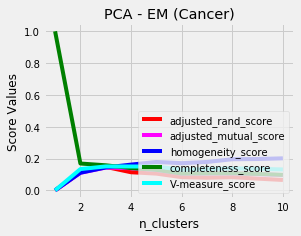

In [296]:
k = [1,2,3,4,5,6,7,8,9,10]
plt.plot(k, ARI, color='red', label='adjusted_rand_score')
plt.plot(k, AMI, color='magenta', label='adjusted_mutual_score')
plt.plot(k, h_score, color='blue', label='homogeneity_score')
plt.plot(k, c_score, color='green', label='completeness_score')
plt.plot(k, V_measure, color='cyan', label='V-measure_score')

plt.legend(loc='lower right')
plt.title("PCA - EM (Cancer)")
#plt.ylim(0.92, 1.01)
#plt.xticks(np.arange(0,2.1,0.5))
plt.xlabel('n_clusters')
plt.ylabel('Score Values');
plt.show()

time:  0.0344970226288
wrongly labeled: 0.434456928839


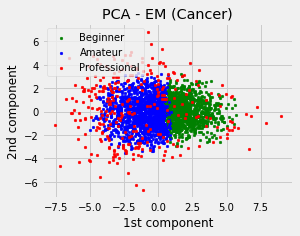

In [299]:
# PCA-EM Plot
start = time()
clf = GMM(n_components=3, covariance_type='spherical', random_state=42)
clf.fit(X_pca)
clusters_ = clf.predict(X_pca)
print 'time: ', time() - start

k = 3 # number of clusters
colors = ['g', 'b', 'r', 'y', 'c', 'm']
labels = ['Beginner', 'Amateur', 'Professional']

# fix labels
clusters_EM = np.choose(clusters_, [1, 0,2])
#clusters_EM = clusters_

fig, ax = plt.subplots()
for i in range(k):
    points = np.array([X_pca[j] for j in range(len(X_pca)) if clusters_EM[j] == i])
    ax.scatter(points[:, 0], points[:, 1], s=7, c=colors[i], label=labels[i])

# wrongly labeled points
points = np.array([X_pca[j] for j in range(len(X_pca)) if y[j] != clusters_EM[j]])
#ax.scatter(points[:, 1], points[:, 2], s=80, facecolors='none', edgecolors='m', label='Wrongly Labeled')
plt.xlabel("1st component")
plt.ylabel("2nd component")
plt.legend(loc=2)
plt.title('PCA - EM (Cancer)')
#plt.text(0.9, 0.9,'time: 9.4 ms', ha='center', va='center', transform=ax.transAxes)
print 'wrongly labeled:', 1.0*len(points)/len(X_pca)

## DR

In [88]:
X_pca = PCA(n_components=9).fit_transform(X)
ica = FastICA(n_components=10, whiten=True)
X_ica =ica.fit_transform(X)
rp = SparseRandomProjection(n_components=10, random_state=10)
X_rp =rp.fit_transform(X)
lda = LDA().fit(X,y)
X_lda = lda.transform(X)

In [89]:
def calc_sse(dataset, clf):
    min_=np.min(np.square(cdist(dataset, clf.cluster_centers_, 'euclidean')), axis = 1)
    sse=np.mean(min_)
    return sse

In [90]:
#find optimized cluster number
sse_ori=[]
sse_pca = []
sse_ica=[]
sse_rp=[]
sse_lda=[]
for k in range(1,11):
    kmeans_ori = KMeans(init='k-means++', n_clusters=k, n_init=10)
    kmeans_ori.fit(X)
    sse_ori.append(calc_sse(X, kmeans_ori))
    
    kmeans_pca = KMeans(init='k-means++', n_clusters=k, n_init=10)
    kmeans_pca.fit(X_pca)
    sse_pca.append(calc_sse(X_pca, kmeans_pca))
    
    kmeans_ica = KMeans(init='k-means++', n_clusters=k, n_init=10)
    kmeans_ica.fit(X_ica)
    sse_ica.append(calc_sse(X_ica, kmeans_ica))
    
    kmeans_rp = KMeans(init='k-means++', n_clusters=k, n_init=10)
    kmeans_rp.fit(X_rp)
    sse_rp.append(calc_sse(X_rp, kmeans_rp))
    
    kmeans_lda = KMeans(init='k-means++', n_clusters=k, n_init=10)
    kmeans_lda.fit(X_lda)
    sse_lda.append(calc_sse(X_lda, kmeans_lda))
    

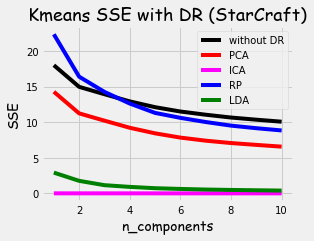

In [91]:
# plot sse
fig = plt.figure()
k = k = [1,2,3,4,5,6,7,8,9,10]
plt.plot(k, sse_ori, color='black', label='without DR')
plt.plot(k, sse_pca, color='red', label='PCA')
plt.plot(k, sse_ica, color='magenta', label='ICA')
plt.plot(k, sse_rp, color='blue', label='RP')
plt.plot(k, sse_lda, color='green', label='LDA')

plt.legend(loc=1)
plt.title("Kmeans SSE with DR (StarCraft)", **cfont)
plt.xlabel('n_components', **vfont)
plt.ylabel('SSE', **vfont);
plt.show()
fig.savefig("star_41.pdf", bbox_inches='tight')




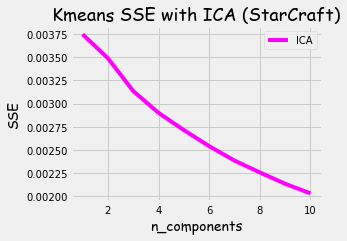

In [92]:
# plot sse
fig = plt.figure()
k = k = [1,2,3,4,5,6,7,8,9,10]
plt.plot(k, sse_ica, color='magenta', label='ICA')

plt.legend(loc=1)
plt.title("Kmeans SSE with ICA (StarCraft)", **cfont)
plt.xlabel('n_components', **vfont)
plt.ylabel('SSE', **vfont);
plt.show()
fig.savefig("star_42.pdf", bbox_inches='tight')



## EM with Dr

In [93]:
ll_ori=[]
ll_pca = []
ll_ica=[]
ll_rp=[]
ll_lda=[]
for k in range(1,11):
    gmm_ori = GMM(n_components=k, covariance_type='spherical')
    gmm_ori.fit(X)
    ll_ori.append(gmm_ori.score(X))
    
    gmm_pca = GMM(n_components=k, covariance_type='spherical')
    gmm_pca.fit(X_pca)
    ll_pca.append(gmm_pca.score(X_pca))

    gmm_ica = GMM(n_components=k, covariance_type='spherical')
    gmm_ica.fit(X_ica)
    ll_ica.append(gmm_ica.score(X_ica))
    
    gmm_rp = GMM(n_components=k, covariance_type='spherical')
    gmm_rp.fit(X_rp)
    ll_rp.append(gmm_rp.score(X_rp))
    
    gmm_lda = GMM(n_components=k, covariance_type='spherical')
    gmm_lda.fit(X_lda)
    ll_lda.append(gmm_lda.score(X_lda))
    

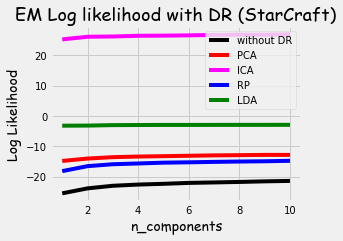

In [94]:
# plot sse
fig = plt.figure()
k = k = [1,2,3,4,5,6,7,8,9,10]
plt.plot(k, ll_ori, color='black', label='without DR')
plt.plot(k, ll_pca, color='red', label='PCA')
plt.plot(k, ll_ica, color='magenta', label='ICA')
plt.plot(k, ll_rp, color='blue', label='RP')
plt.plot(k, ll_lda, color='green', label='LDA')

plt.legend(loc=1)
plt.title("EM Log likelihood with DR (StarCraft)", **cfont)
plt.xlabel('n_components', **vfont)
plt.ylabel('Log Likelihood', **vfont);
plt.show()
fig.savefig("star_43.pdf", bbox_inches='tight')



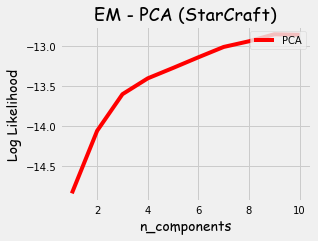

In [95]:
# plot sse
fig = plt.figure()
k = k = [1,2,3,4,5,6,7,8,9,10]
plt.plot(k, ll_pca, color='red', label='PCA')


plt.legend(loc=1)
plt.title("EM - PCA (StarCraft)", **cfont)
plt.xlabel('n_components', **vfont)
plt.ylabel('Log Likelihood', **vfont)
plt.show()
fig.savefig("star_44.pdf", bbox_inches='tight')



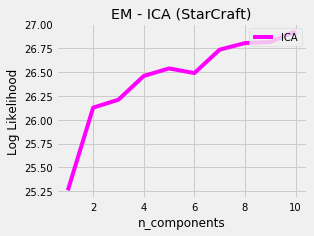

In [308]:
# plot sse
k = k = [1,2,3,4,5,6,7,8,9,10]

plt.plot(k, ll_ica, color='magenta', label='ICA')

plt.legend(loc=1)
plt.title("EM - ICA (StarCraft)")
plt.xlabel('n_components')
plt.ylabel('Log Likelihood');
plt.show()

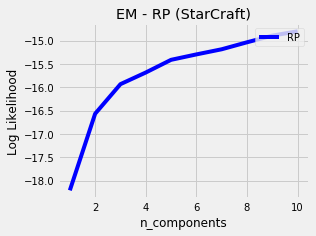

In [309]:
# plot sse
k = k = [1,2,3,4,5,6,7,8,9,10]
plt.plot(k, ll_rp, color='blue', label='RP')

plt.legend(loc=1)
plt.title("EM - RP (StarCraft)")
plt.xlabel('n_components')
plt.ylabel('Log Likelihood');
plt.show()

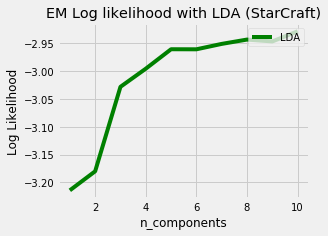

In [310]:
# plot sse
k = k = [1,2,3,4,5,6,7,8,9,10]
plt.plot(k, ll_lda, color='green', label='LDA')

plt.legend(loc=1)
plt.title("EM Log likelihood with LDA (StarCraft)")
plt.xlabel('n_components')
plt.ylabel('Log Likelihood');
plt.show()

## Clustering time

In [311]:
# Kmeans
k = 3

start = time()
kmeans_ori = KMeans(init='k-means++', n_clusters=k, n_init=10)
kmeans_ori.fit(X)
print 'ori time', time() - start

start = time()
kmeans_pca = KMeans(init='k-means++', n_clusters=k, n_init=10)
kmeans_pca.fit(X_pca)
print 'pca time', time() - start

start = time()
kmeans_ica = KMeans(init='k-means++', n_clusters=k, n_init=10)
kmeans_ica.fit(X_ica)
print 'ica time', time() - start

start = time()
kmeans_rp = KMeans(init='k-means++', n_clusters=k, n_init=10)
kmeans_rp.fit(X_rp)
print 'rp time', time() - start

start = time()    
kmeans_lda = KMeans(init='k-means++', n_clusters=k, n_init=10)
kmeans_lda.fit(X_lda)
print 'lda time', time() - start

ori time 0.164601802826
pca time 0.106112003326
ica time 0.128716945648
rp time 0.100560188293
lda time 0.0512738227844


In [312]:
# EM
k = 3

start = time()
gmm_ori = GMM(n_components=k, covariance_type='spherical')
gmm_ori.fit(X)
print 'ori time', time() - start  

gmm_pca = GMM(n_components=k, covariance_type='spherical')
gmm_pca.fit(X_pca)
print 'pca time', time() - start

gmm_ica = GMM(n_components=k, covariance_type='spherical')
gmm_ica.fit(X_ica)
print 'ica time', time() - start
    
gmm_rp = GMM(n_components=k, covariance_type='spherical')
gmm_rp.fit(X_rp)
print 'rp time', time() - start
    
gmm_lda = GMM(n_components=k, covariance_type='spherical')
gmm_lda.fit(X_lda)
print 'lda time', time() - start

ori time 0.037113904953
pca time 0.0717098712921
ica time 0.10490489006
rp time 0.132551908493
lda time 0.15161895752


## ica plot

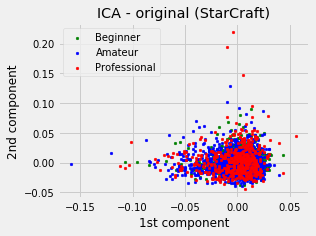

In [313]:
k = 3 # number of clusters
colors = ['g', 'b', 'r', 'y', 'c', 'm']
labels = ['Beginner', 'Amateur', 'Professional']


fig, ax = plt.subplots()
for i in range(k):
    points = np.array([X_ica[j] for j in range(len(X_ica)) if y[j] == i])
    ax.scatter(points[:, 0], points[:, 1], s=7, c=colors[i], label=labels[i])

plt.xlabel("1st component")
plt.ylabel("2nd component")
plt.legend(loc=2)
plt.title('ICA - original (StarCraft)')

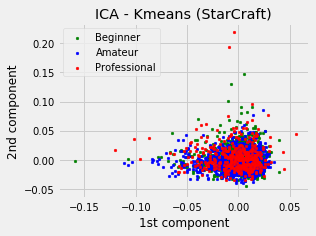

In [314]:
# ICA - Kmeans
clf = KMeans(init='k-means++', n_clusters=3, random_state=42)
clf.fit_predict(X_ica)

k = 3 # number of clusters
colors = ['g', 'b', 'r', 'y', 'c', 'm']
labels = ['Beginner', 'Amateur', 'Professional']

# fix labels
clusters_kmeans = np.choose(clf.labels_, [1, 0, 2])

fig, ax = plt.subplots()
for i in range(k):
    points = np.array([X_ica[j] for j in range(len(X_ica)) if clusters_kmeans[j] == i])
    ax.scatter(points[:, 0], points[:, 1], s=7, c=colors[i], label=labels[i])

plt.xlabel("1st component")
plt.ylabel("2nd component")
plt.legend(loc=2)
plt.title('ICA - Kmeans (StarCraft)')

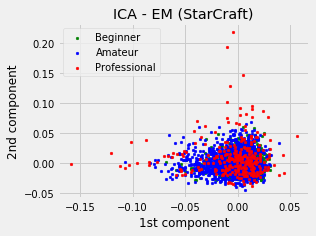

In [316]:
# ICA - EM
clf = GMM(n_components=3, covariance_type='spherical', random_state=42)
clf.fit(X_ica)
clusters_ = clf.predict(X_ica)

k = 3 # number of clusters
colors = ['g', 'b', 'r', 'y', 'c', 'm']
labels = ['Beginner', 'Amateur', 'Professional']

# fix labels
clusters_kmeans = np.choose(clusters_, [1, 0, 2])

fig, ax = plt.subplots()
for i in range(k):
    points = np.array([X_ica[j] for j in range(len(X_ica)) if clusters_EM[j] == i])
    ax.scatter(points[:, 0], points[:, 1], s=7, c=colors[i], label=labels[i])

plt.xlabel("1st component")
plt.ylabel("2nd component")
plt.legend(loc=2)
plt.title('ICA - EM (StarCraft)')

## RP plots

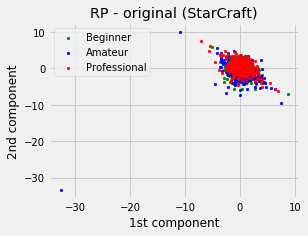

In [317]:
# rp original
k = 3 # number of clusters
colors = ['g', 'b', 'r', 'y', 'c', 'm']
labels = ['Beginner', 'Amateur', 'Professional']

fig, ax = plt.subplots()
for i in range(k):
    points = np.array([X_rp[j] for j in range(len(X_rp)) if y[j] == i])
    ax.scatter(points[:, 0], points[:, 1], s=7, c=colors[i], label=labels[i])

plt.xlabel("1st component")
plt.ylabel("2nd component")
plt.legend(loc=2)
plt.title('RP - original (StarCraft)')

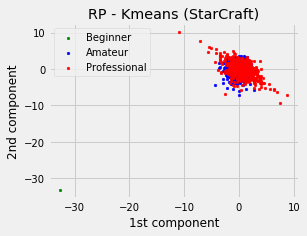

In [322]:
# RP - Kmeans
clf = KMeans(init='k-means++', n_clusters=3, random_state=42)
clf.fit_predict(X_rp)

k = 3 # number of clusters
colors = ['g', 'b', 'r', 'y', 'c', 'm']
labels = ['Beginner', 'Amateur', 'Professional']

# fix labels
clusters_kmeans = np.choose(clf.labels_, [1, 2,0])

fig, ax = plt.subplots()
for i in range(k):
    points = np.array([X_rp[j] for j in range(len(X_rp)) if clusters_kmeans[j] == i])
    ax.scatter(points[:, 0], points[:, 1], s=7, c=colors[i], label=labels[i])

plt.xlabel("1st component")
plt.ylabel("2nd component")
plt.legend(loc=2)
plt.title('RP - Kmeans (StarCraft)')

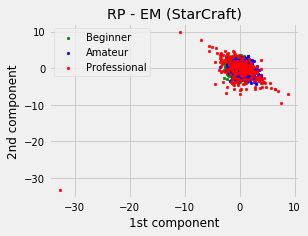

In [323]:
# RP - EM
clf = GMM(n_components=3, covariance_type='spherical', random_state=42)
clf.fit(X_rp)
clusters_ = clf.predict(X_rp)

k = 3 # number of clusters
colors = ['g', 'b', 'r', 'y', 'c', 'm']
labels = ['Beginner', 'Amateur', 'Professional']

# fix labels
clusters_EM = np.choose(clusters_, [1, 0,2])
#clusters_EM=clusters_

fig, ax = plt.subplots()
for i in range(k):
    points = np.array([X_rp[j] for j in range(len(X_rp)) if clusters_EM[j] == i])
    ax.scatter(points[:, 0], points[:, 1], s=7, c=colors[i], label=labels[i])

plt.xlabel("1st component")
plt.ylabel("2nd component")
plt.legend(loc=2)
plt.title('RP - EM (StarCraft)')

## LDA plot

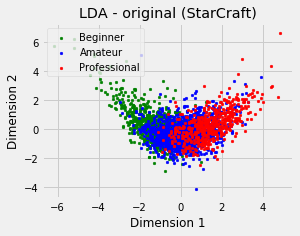

In [325]:
# lda original
k = 3 # number of clusters
colors = ['g', 'b', 'r', 'y', 'c', 'm']
labels = ['Beginner', 'Amateur', 'Professional']

fig, ax = plt.subplots()
for i in range(k):
    points = np.array([X_lda[j] for j in range(len(X_lda)) if y[j] == i])
    ax.scatter(points[:, 0], points[:, 1], s=7, c=colors[i], label=labels[i])

plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(loc=2)
plt.title('LDA - original (StarCraft)')

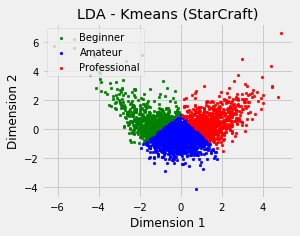

In [334]:
# LDa - Kmeans
clf = KMeans(init='k-means++', n_clusters=3, random_state=42)
clf.fit_predict(X_lda)

k = 3 # number of clusters
colors = ['g', 'b', 'r', 'y', 'c', 'm']
labels = ['Beginner', 'Amateur', 'Professional']

# fix labels
clusters_kmeans = np.choose(clf.labels_, [2,1,0])
#clusters_kmeans=clf.labels_

fig, ax = plt.subplots()
for i in range(k):
    points = np.array([X_lda[j] for j in range(len(X_lda)) if clusters_kmeans[j] == i])
    ax.scatter(points[:, 0], points[:, 1], s=7, c=colors[i], label=labels[i])

plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(loc=2)
plt.title('LDA - Kmeans (StarCraft)')

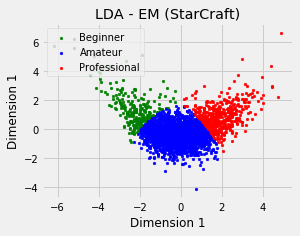

In [338]:
# LDA - EM
clf = GMM(n_components=3, covariance_type='spherical', random_state=42)
clf.fit(X_lda)
clusters_ = clf.predict(X_lda)

k = 3 # number of clusters
colors = ['g', 'b', 'r', 'y', 'c', 'm']
labels = ['Beginner', 'Amateur', 'Professional']

# fix labels
clusters_EM = np.choose(clusters_, [2,0,1])
#clusters_EM=clusters_

fig, ax = plt.subplots()
for i in range(k):
    points = np.array([X_lda[j] for j in range(len(X_lda)) if clusters_EM[j] == i])
    ax.scatter(points[:, 0], points[:, 1], s=7, c=colors[i], label=labels[i])

plt.xlabel("Dimension 1")
plt.ylabel("Dimension 1")
plt.legend(loc=2)
plt.title('LDA - EM (StarCraft)')